In [1]:
import ast
import re
from PIL import Image
from colormath.color_objects import LCHabColor, sRGBColor
from colormath.color_conversions import convert_color
import math
import pandas as pd
from openai import OpenAI
import base64
import requests
import random
import pathlib as plib
import pickle
import json
import numpy as np
import scipy.stats
import itertools
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import json
import statsmodels.api as sm
from collections import defaultdict 
import logging 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

In [14]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler("./run.log", mode = 'a', encoding='utf-8')
file_handler.setFormatter(logging.Formatter('[%(levelname)s] %(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p'))
logger.addHandler(file_handler)

In [8]:
for handler in logger.handlers[:]:
    handler.close()
    logger.removeHandler(handler)

# Generate Stimuli

The result stimuli are uploaded to https://github.com/yikun-chi/gptemo

In [2]:
# stimuli.csv is obtained through https://link.springer.com/article/10.1007/s00426-017-0880-8/tables/1 

# C is obtained by sat * l 
df_stimuli = pd.read_csv("./stimuli.csv")
df_stimuli

,Hue,Brightness,Saturation,L,sat,h,C
0,Blue,High,High,50.00,2.31,5.06,115.5000
1,Blue,High,Medium,50.00,1.40,5.06,70.0000
2,Blue,High,Low,49.99,0.48,5.04,23.9952
3,Blue,Medium,High,34.99,2.28,5.07,79.7772
4,Blue,Medium,Medium,34.99,1.39,5.09,48.6361
5,Blue,Medium,Low,34.95,0.53,5.07,18.5235
6,Blue,Low,High,19.96,2.34,5.08,46.7064
7,Blue,Low,Medium,19.89,1.45,4.99,28.8405
8,Blue,Low,Low,20.10,0.52,5.06,10.4520
9,Green,High,High,50.03,2.26,2.63,113.0678


In [5]:
# create the color block stimuli and print the RGB value equivalent to create the website stimuli 
for i in range(27):
  l = df_stimuli.loc[i, "L"]
  c = df_stimuli.loc[i, "C"]
  h = math.degrees(df_stimuli.loc[i, "h"])
  
  lch_color = LCHabColor(lch_l= l, lch_c = c , lch_h = h, observer='10', illuminant='d65')
  
  rgb_color = convert_color(lch_color, sRGBColor)
  rgb_color = int(rgb_color.clamped_rgb_r * 255), int(rgb_color.clamped_rgb_g * 255), int(rgb_color.clamped_rgb_b * 255)
  print(i, rgb_color)
  size = (512, 512)
  image = Image.new("RGB", size, color=rgb_color)

  image.save(f"./color_stimuli/img_{i}.jpg", "JPEG")

0 (0, 110, 255)
1 (63, 112, 230)
2 (111, 116, 156)
3 (0, 75, 203)
4 (57, 76, 153)
5 (77, 80, 108)
6 (0, 43, 112)
7 (28, 46, 88)
8 (46, 47, 62)
9 (0, 148, 0)
10 (0, 141, 58)
11 (86, 128, 95)
12 (0, 102, 0)
13 (0, 97, 41)
14 (57, 89, 65)
15 (0, 59, 0)
16 (4, 55, 34)
17 (38, 51, 43)
18 (245, 0, 0)
19 (209, 72, 41)
20 (158, 106, 91)
21 (169, 3, 0)
22 (143, 53, 29)
23 (108, 73, 65)
24 (98, 16, 0)
25 (82, 32, 33)
26 (61, 44, 42)


# Generate Trails 

Create pariwsise and non-pariwise trails 

In [149]:
# ignore grey condition, and get only Hue, Brightness, and Saturation 
df_stimuli = pd.read_csv("./stimuli.csv").loc[0:26,['Hue','Brightness','Saturation']]

## Pairwise Trails 
All combination (order sensitive) of pairwise comparison, each pair is repeated 5 times 

In [158]:
# Record brightness and saturation 
df_stimuli['Brightness'] = df_stimuli['Brightness'].replace({'High': 2, 'Medium': 1, 'Low': 0})
df_stimuli['Saturation'] = df_stimuli['Saturation'].replace({'High': 2, 'Medium': 1, 'Low': 0})


# Get all pairwise combination 
all_pairwise_list = list(itertools.combinations(df_stimuli.index, 2))
df_trails = []

for pair in all_pairwise_list:
    stimulus_0 = pair[0]
    stimulus_1 = pair[1]

    stimulus_0_hue = df_stimuli.loc[stimulus_0, 'Hue']
    stimulus_1_hue = df_stimuli.loc[stimulus_1, 'Hue']

    if stimulus_0_hue == stimulus_1_hue:
        green_blue_diff = 0
        red_blue_diff = 0
        green_red_diff = 0
    elif stimulus_0_hue == 'Blue' and stimulus_1_hue == 'Green':
        green_blue_diff = 1
        red_blue_diff = 0
        green_red_diff = 0
    elif stimulus_0_hue == 'Blue' and stimulus_1_hue == 'Red':
        green_blue_diff = 0
        red_blue_diff = 1
        green_red_diff = 0
    elif stimulus_0_hue == 'Green' and stimulus_1_hue == 'Blue':
        green_blue_diff = -1
        red_blue_diff = 0
        green_red_diff = 0
    elif stimulus_0_hue == 'Green' and stimulus_1_hue == 'Red':
        green_blue_diff = 0
        red_blue_diff = 0
        green_red_diff = -1
    elif stimulus_0_hue == 'Red' and stimulus_1_hue == 'Blue':
        green_blue_diff = 0
        red_blue_diff = -1
        green_red_diff = 0
    elif stimulus_0_hue == 'Red' and stimulus_1_hue == 'Green':
        green_blue_diff = 0
        red_blue_diff = 0
        green_red_diff = 1
    else:
        raise ValueError('Unaccounted stimuli combination')

    df_trails += [{'stimulus_0': stimulus_0, 'stimulus_1': stimulus_1,
    'brightness_diff': df_stimuli.loc[stimulus_1, 'Brightness'] - df_stimuli.loc[stimulus_0, 'Brightness'],
    'saturation_diff': df_stimuli.loc[stimulus_1, 'Saturation'] - df_stimuli.loc[stimulus_0, 'Saturation'],
    'green_blue_diff': green_blue_diff,
    'red_blue_diff':red_blue_diff,
    'green_red_diff': green_red_diff
    }] * 5

    # switch the order of the stimuli 
    stimulus_0 = pair[1]
    stimulus_1 = pair[0]
    df_trails += [{'stimulus_0': stimulus_0, 'stimulus_1': stimulus_1,
    'brightness_diff': df_stimuli.loc[stimulus_1, 'Brightness'] - df_stimuli.loc[stimulus_0, 'Brightness'],
    'saturation_diff': df_stimuli.loc[stimulus_1, 'Saturation'] - df_stimuli.loc[stimulus_0, 'Saturation'],
    'green_blue_diff': green_blue_diff * -1 ,
    'red_blue_diff':red_blue_diff * -1 ,
    'green_red_diff': green_red_diff * -1 
    }] * 5

df_trails = pd.DataFrame(df_trails).reset_index()
df_trails.to_pickle("./df_trails_pairwise.pkl")


# show some example 
print(df_trails.shape)
display(df_trails.iloc[[0, 10, 20, 30],:])
display(df_stimuli.iloc[[0,1,2,3,4], :])


(3510, 8)


,index,stimulus_0,stimulus_1,brightness_diff,saturation_diff,green_blue_diff,red_blue_diff,green_red_diff
0,0,0,1,0,-1,0,0,0
10,10,0,2,0,-2,0,0,0
20,20,0,3,-1,0,0,0,0
30,30,0,4,-1,-1,0,0,0


,Hue,Brightness,Saturation
0,Blue,2,2
1,Blue,2,1
2,Blue,2,0
3,Blue,1,2
4,Blue,1,1


## Non-pairwise trails 
Each stimuli is repeated 100 times 

In [178]:
# Constructing non-pairwise trails 
df_stimuli_encoded = pd.get_dummies(df_stimuli, columns=['Hue']).reset_index()
df_stimuli_encoded.rename(columns = {'index':'stimuli'}, inplace = True)
df_stimuli_encoded = pd.DataFrame(np.repeat(df_stimuli_encoded.values, 100, axis=0), columns = df_stimuli_encoded.columns).reset_index()
print(df_stimuli_encoded.shape)
df_stimuli_encoded.head(5)

df_stimuli_encoded[['stimuli', 'Brightness', 'Saturation', 'Hue_Blue', 'Hue_Green', 'Hue_Red']] = df_stimuli_encoded[['stimuli', 'Brightness', 'Saturation', 'Hue_Blue', 'Hue_Green', 'Hue_Red']].astype(int)

#df_stimuli_encoded.to_pickle("./df_trails.pkl")

(2700, 7)


# Prompt Testing 

In [50]:
# Function to encode the image
client = OpenAI(api_key = api_key)

#context_prompt = "Imagine you are browsing the Internet and encountering a website as provided." 
#measure_prompt = "Question 1: Rate your feeling in terms of pleasantness from 1 to 9 where 1 is unpleasant and 9 is pleasant.  Question 2: Rate your feeling in terms of excitedness from 1 to 9 where 1 is calm and 9 is excited. "
#regulation_prompt = "Return only in the format of {'Q1': your_response, 'Q2': your_response} where your resposne is the numeric rating between 1 to 9." 
#final_prompt = context_prompt + measure_prompt + regulation_prompt



final_prompt = "If I yell at you, would you respond more aggressive with your response"
response = client.chat.completions.create(
  model= "gpt-4o", #gpt-4-vision-preview
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": final_prompt,
        },
        {
        "type": "image_url",
        "image_url": {
            "url": f"https://github.com/yikun-chi/gptemo/blob/main/Images/Barbeque 1.jpg?raw=true" # f"https://github.com/yikun-chi/gptemo/blob/main/website_stimuli/img_{0}.jpg?raw=true"
            
        },
        },
      ],
    }
  ],
  max_tokens=300,
  temperature = 0
)
response.choices[0].message.content

'No, I would not respond aggressively. My purpose is to provide helpful and respectful responses regardless of the tone or manner in which questions are asked. If you have any questions or need assistance, feel free to ask!'

# Prompt Batching and Running 

In [20]:
client = OpenAI(api_key = api_key)

In [41]:
prompt_bank = {}
## Common Measure Prompt 
pairwise_feeling_measure_prompt = "Question 1: Which one would you feel more pleasant? Question 2: Which one would you feel more exciting? "
pairwise_knowledge_measure_prompt = "Question 1: Which one would people rate as more pleasant? Question 2: Which one would people rate as more exciting? "
rating_feeling_measure_prompt = "Question 1: Rate your feeling in terms of pleasantness from 1 to 9 where 1 is unpleasant and 9 is pleasant.  Question 2: Rate your feeling in terms of excitedness from 1 to 9 where 1 is calm and 9 is excited. "
rating_knowledge_measure_prompt = "Question 1: How would people rate in terms of pleasantness from 1 to 9, where 1 is unpleasant, and 9 is pleasant? Question 2: How would people rate in terms of excitedness from 1 to 9, where 1 is calm and 9 is excited? "

## Common regulation prompt 
paiwrise_regulation_prompt = "Return only in the format of {'Q1': your_response, 'Q2': your_response}. Respond only in 1 or 2. " 
rating_regualtion_prompt = "Return only in the format of {'Q1': your_response, 'Q2': your_response} where your resposne is the numeric rating between 1 to 9." 


#### Color Experiment 
prompt_bank['color'] = {}

prompt_bank['color']['pairwise-feeling'] = "Imagine you are shown two different colors, shown in pictures 1 and 2. " + pairwise_feeling_measure_prompt + paiwrise_regulation_prompt
prompt_bank['color']['pairwise-knowledge'] = "Many people have been shown two different colors (picture 1 and picture 2) and asked to rate how they feel about the color. "  + pairwise_knowledge_measure_prompt + paiwrise_regulation_prompt
prompt_bank['color']['rating-feeling'] = "Imagine you are shown a color as shown in provided picture. " + rating_feeling_measure_prompt + rating_regualtion_prompt
prompt_bank['color']['rating-knowledge'] = "Many people have been shown a color as provided and asked to rate how they feel. "  + rating_knowledge_measure_prompt + rating_regualtion_prompt


## Website Experiment 
prompt_bank['website'] = {}
prompt_bank['website']['pairwise-feeling'] = "Imagine you are browsing the Internet and encountering two different websites, shown in pictures 1 and 2. "  + pairwise_feeling_measure_prompt + paiwrise_regulation_prompt
prompt_bank['website']['pairwise-knowledge'] = "Many people have been shown two website designs (picture 1 and picture 2) and asked to rate how they feel about the design. " + pairwise_knowledge_measure_prompt + paiwrise_regulation_prompt
prompt_bank['website']['rating-feeling'] = "Imagine you are browsing the Internet and encountering a website as shown in provided picture. "  + rating_feeling_measure_prompt + rating_regualtion_prompt
prompt_bank['website']['rating-knowledge'] = "Many people have been shown a website design as provided and asked to rate how they feel about the design. " + rating_knowledge_measure_prompt + rating_regualtion_prompt

for exp, val in prompt_bank.items():
    print(f"----------------{exp}----------------------")
    for condition, prompt in val.items(): 
        print(f"--{condition} ")
        print(prompt)



----------------color----------------------
--pairwise-feeling 
Imagine you are shown two different colors, shown in pictures 1 and 2. Question 1: Which one would you feel more pleasant? Question 2: Which one would you feel more exciting? Return only in the format of {'Q1': your_response, 'Q2': your_response}. Respond only in 1 or 2. 
--pairwise-knowledge 
Many people have been shown two different colors (picture 1 and picture 2) and asked to rate how they feel about the color. Question 1: Which one would people rate as more pleasant? Question 2: Which one would people rate as more exciting? Return only in the format of {'Q1': your_response, 'Q2': your_response}. Respond only in 1 or 2. 
--rating-feeling 
Imagine you are shown a color as shown in provided picture. Question 1: Rate your feeling in terms of pleasantness from 1 to 9 where 1 is unpleasant and 9 is pleasant.  Question 2: Rate your feeling in terms of excitedness from 1 to 9 where 1 is calm and 9 is excited. Return only in t

In [193]:
# Generate jsonl file for the experiment

df_trails_pariwise = pd.read_pickle("./df_trails_pairwise.pkl")
df_trails = pd.read_pickle("./df_trails.pkl")

for experiment, content in prompt_bank.items(): 
    for condition, prompt in content.items():
        request_ls = []
        if 'pairwise' in condition:
            df = df_trails_pariwise
        else:
            df = df_trails
        
        for idx, row in df.iterrows(): 
            # setting consistent across both condition 
            request_dict = {}
            request_dict['custom_id'] = f"row_{idx}"
            request_dict['method'] = "POST"
            request_dict['url'] = "/v1/chat/completions"
            request_dict['body'] = {}
            request_dict['body']['model'] = 'gpt-4o'
            request_dict['body']['max_tokens'] = 30   
            request_dict['body']['temperature'] = 0.2 

            if 'pairwise' in condition: 
                request_dict['body']['messages'] = [
                    {
                    "role": "user",
                    "content": [
                        {
                        "type": "text",
                        "text": prompt,
                        },
                        {
                        "type": "image_url",
                        "image_url": {
                            "url": f"https://github.com/yikun-chi/gptemo/blob/main/{experiment}_stimuli/img_{row['stimulus_0']}.jpg?raw=true"
                            
                        },
                        },
                        {
                        "type": "image_url",
                        "image_url": {
                            "url": f"https://github.com/yikun-chi/gptemo/blob/main/{experiment}_stimuli/img_{row['stimulus_1']}.jpg?raw=true"
                        },
                        },
                    ],
                    }
                ]
            else: 
                request_dict['body']['messages'] = [
                    {
                    "role": "user",
                    "content": [
                        {
                        "type": "text",
                        "text": prompt,
                        },
                        {
                        "type": "image_url",
                        "image_url": {
                            "url": f"https://github.com/yikun-chi/gptemo/blob/main/{experiment}_stimuli/img_{row['stimuli']}.jpg?raw=true"
                            
                        },
                        },
                    ],
                    }
                ]
            request_ls.append(request_dict)
        
        with open(f'./request/request_{experiment}_{condition}.jsonl', 'w') as file:
            # Iterate over each dictionary in the list
            for entry in request_ls:
                # Convert dictionary to JSON string
                json_str = json.dumps(entry)
                # Write the JSON string to the file with a newline
                file.write(json_str + '\n')

# each file is tested to make sure that the image dir is correct 

In [194]:
# Submit all batch files to API 

logger.info("Run Started")

all_request = list((plib.Path.cwd() / "request").rglob('*.jsonl'))

for request in all_request: 
    batch_input_file = client.files.create(file = open(request, "rb"), purpose = "batch")
    batch_input_file_id = batch_input_file.id
    bath_job = client.batches.create(input_file_id = batch_input_file_id, endpoint="/v1/chat/completions",completion_window="24h", metadata={"description": request.stem})

    logger.info(f"Request {request.stem} is submitted with batch id {bath_job.id}")

In [274]:
all_request

[WindowsPath('c:/Users/yikun/OneDrive/Documents/Work/ChatGPT Emotion Project/request/request_color_pairwise-feeling.jsonl'),
 WindowsPath('c:/Users/yikun/OneDrive/Documents/Work/ChatGPT Emotion Project/request/request_color_pairwise-knowledge.jsonl'),
 WindowsPath('c:/Users/yikun/OneDrive/Documents/Work/ChatGPT Emotion Project/request/request_color_rating-feeling.jsonl'),
 WindowsPath('c:/Users/yikun/OneDrive/Documents/Work/ChatGPT Emotion Project/request/request_color_rating-knowledge.jsonl'),
 WindowsPath('c:/Users/yikun/OneDrive/Documents/Work/ChatGPT Emotion Project/request/request_website_pairwise-feeling.jsonl'),
 WindowsPath('c:/Users/yikun/OneDrive/Documents/Work/ChatGPT Emotion Project/request/request_website_pairwise-knowledge.jsonl'),
 WindowsPath('c:/Users/yikun/OneDrive/Documents/Work/ChatGPT Emotion Project/request/request_website_rating-feeling.jsonl'),
 WindowsPath('c:/Users/yikun/OneDrive/Documents/Work/ChatGPT Emotion Project/request/request_website_rating-knowledge.j

In [209]:
# Code chunk used to individually download the result. 
batch_status = client.batches.retrieve("")
print(batch_status.status)
if batch_status.status == 'completed':
    result_content = client.files.content(batch_status.output_file_id)
    result_content.write_to_file(f"./result/{batch_status.metadata['description']}.jsonl")
    logger.info(f"Result for {batch_status.metadata['description']} trail with batch id {batch_status.id} is downloaded")

completed


In [288]:
# Running Actual Experiment and 
all_result = list((plib.Path.cwd() / "result").rglob('*.jsonl'))
df_trails_pariwise = pd.read_pickle("./df_trails_pairwise.pkl")
df_trails = pd.read_pickle("./df_trails.pkl")

for result in all_result:
    exp = result.stem.split("_")[1]
    condition =  result.stem.split("_")[2]

    if "pairwise" in condition:
        df = df_trails_pariwise
    else:
        df = df_trails
    
    # read in the result jsonl file 
    df_res = []
    with open(result) as f:
        for line in f:
            j_content = json.loads(line)
            df_res.append({'id': j_content['custom_id'], 'response': j_content['response']['body']['choices'][0]['message']['content']})
    df_res = pd.DataFrame(df_res)
    df_res['id'] = df_res['id'].str.replace("row_", "").astype(int)
    df_res['valence'] = df_res['response'].apply(lambda x: ast.literal_eval(x)['Q1'])
    df_res['arousal'] = df_res['response'].apply(lambda x: ast.literal_eval(x)['Q2'])
    if "pairwise" in condition: 
        df_res['valence'] = df_res['valence'] - 1
        df_res['arousal'] = df_res['arousal'] - 1

    # merge with the input trail dataframe 
    df_res = df.merge(df_res, left_on = 'index', right_on = 'id', how = 'left')
    df_res.to_pickle(f"./result/{exp}_{condition}.pkl")

# Result Analysis

(2699, 11)


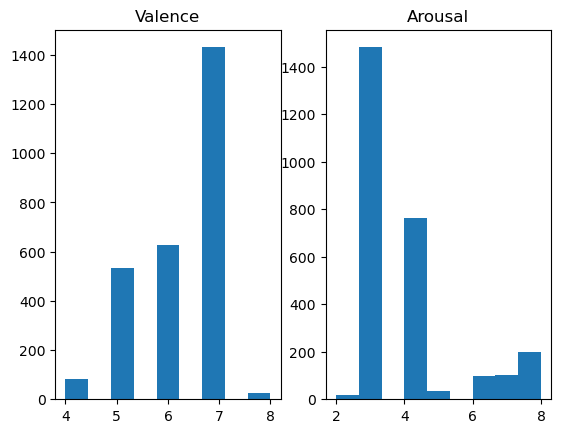

In [143]:
exp = 'color'   # color / website 
condition = 'rating-feeling' # rating-feeling / pairwise-knowledge / rating-feeling / rating-knowledge

df = pd.read_pickle(f"./result/{exp}_{condition}.pkl").dropna(subset = ['valence', 'arousal'])
print(df.shape)


fig, axes = plt.subplots(1, 2)
axes[0].hist(df['valence'], bins = 9)
axes[0].set_title("Valence")
axes[1].hist(df['arousal'], bins = 9)
axes[1].set_title("Arousal")
plt.show()


In [144]:
### Investigate the distribtion of the result across different conditions 

if "pairwise" in condition: 

    total_number_of_combination = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff']].drop_duplicates().shape[0]
    # Investigation of the distribution of valence rating 
    df_valence = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff', 'valence']]
    df_valence_groupby = df_valence.groupby(['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff'])['valence'].unique().reset_index()
    df_valence_groupby['unique_cnt'] = df_valence_groupby['valence'].apply(lambda x: len(x))
    df_valence_groupby = df_valence_groupby.loc[df_valence_groupby['unique_cnt'] == 1, :]
    print(f" {df_valence_groupby.shape[0]} out of {total_number_of_combination} input combination contains only one unique value (always picking one of the two stimuli as more pleasant")

    # Investigation of the distribution of arousal rating 
    df_arousal = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff', 'arousal']]
    df_arousal_groupby = df_arousal.groupby(['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff'])['arousal'].unique().reset_index()
    df_arousal_groupby['unique_cnt'] = df_arousal_groupby['arousal'].apply(lambda x: len(x))
    df_arousal_groupby = df_arousal_groupby.loc[df_arousal_groupby['unique_cnt'] == 1, :]
    print(f" {df_arousal_groupby.shape[0]} out of {total_number_of_combination} stimuli pair contains only one unique value (always picking one of the two stimuli as more exciting")

else: 
    total_number_of_combination = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red']].drop_duplicates().shape[0]
    # Investigation of the distribution of valence rating 
    df_valence = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red', 'valence']]
    df_valence_groupby = df_valence.groupby(['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red'])['valence'].unique().reset_index()
    df_valence_groupby['unique_cnt'] = df_valence_groupby['valence'].apply(lambda x: len(x))
    df_valence_groupby = df_valence_groupby.loc[df_valence_groupby['unique_cnt'] == 1, :]
    print(f" {df_valence_groupby.shape[0]} out of {total_number_of_combination} stimuli contains only one unique value (always rate the same valence rating)")

    # Investigation of the distribution of arousal rating
    df_arousal = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red', 'arousal']]
    df_arousal_groupby = df_arousal.groupby(['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red'])['arousal'].unique().reset_index()
    df_arousal_groupby['unique_cnt'] = df_arousal_groupby['arousal'].apply(lambda x: len(x))
    df_arousal_groupby = df_arousal_groupby.loc[df_arousal_groupby['unique_cnt'] == 1, :]
    print(f" {df_arousal_groupby.shape[0]} out of {total_number_of_combination} stimuli contains only one unique value (always rate the same arousal rating)")

 10 out of 27 stimuli contains only one unique value (always rate the same valence rating)
 12 out of 27 stimuli contains only one unique value (always rate the same arousal rating)


In [61]:
# Manual noise adding step 
manual_noise = True
if manual_noise: 
    if "pairwise" in condition: 
        # In pairwise condition, if a combination of X has only 1 value for valence / arousal, add one row with opposite value
        # Otherwise violates the assumption of the logistic model 
        df_valence_groupby['valence'] = 1 - df_valence_groupby['valence'].apply(lambda x: x[0]) 
        df_valence = pd.concat([df_valence, df_valence_groupby.drop(['unique_cnt'], axis = 1)])

        df_arousal_groupby['arousal'] = 1 - df_arousal_groupby['arousal'].apply(lambda x: x[0])
        df_arousal = pd.concat([df_arousal, df_arousal_groupby.drop(['unique_cnt'], axis = 1)])
    else: 
        # In rating condition, if a combination of X has only 1 value for valence / arousal, add one row with opposite value (10 - value) 
        # Technically this is not required as in the logistic model case, but for consistency / also make the model run without changing the result 
        df_valence_groupby['valence'] = 10 - df_valence_groupby['valence'].apply(lambda x: x[0])
        df_valence = pd.concat([df_valence, df_valence_groupby], axis = 0)

        df_arousal_groupby['arousal'] = 10 - df_arousal_groupby['arousal'].apply(lambda x: x[0])
        df_arousal = pd.concat([df_arousal, df_arousal_groupby], axis = 0) 
else: 
    if "pairwise" in condition: 
        df_valence = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff', 'valence']]
        df_arousal = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff', 'arousal']]
    else: 
        df_valence = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red', 'valence']]
        df_arousal = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red', 'arousal']]



if "pairwise" in condition: 
    print("\n--------------Valence Model Result----------------")
    iv_array = sm.add_constant(df_valence[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff']])
    dv_array = df_valence['valence']
    try:
        model = sm.Logit(dv_array, iv_array)
        model_fit = model.fit()
        print(model_fit.summary())
    except Exception as msg: 
        print("Valence Model Failed")
        print(msg)

    print("\n--------------Arousal Model Result----------------")
    iv_array = sm.add_constant(df_arousal[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff']])
    dv_array = df_arousal['arousal']
    try:
        model = sm.Logit(dv_array, iv_array)
        model_fit = model.fit()
        print(model_fit.summary())
    except Exception as msg: 
        print("Valence Model Failed")
        print(msg)
else: 
    print("\n--------------Valence Model Result----------------")
    iv_array = sm.add_constant(df_valence[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red']])
    dv_array = df_valence['valence']
    try:
        model = sm.OLS(dv_array, iv_array)
        model_fit = model.fit()
        print(model_fit.summary())
    except Exception as msg: 
        print("Valence Model Failed")
        print(msg)

    print("\n--------------Arousal Model Result----------------")
    iv_array = sm.add_constant(df_arousal[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red']])
    dv_array = df_arousal['arousal']
    model = sm.OLS(dv_array, iv_array)
    model_fit = model.fit()
    print(model_fit.summary())


--------------Valence Model Result----------------
                            OLS Regression Results                            
Dep. Variable:                valence   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     0.000
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               1.00
Time:                        14:52:00   Log-Likelihood:                -1343.6
No. Observations:                2727   AIC:                             2697.
Df Residuals:                    2722   BIC:                             2727.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


# Discussion 

## Perception Investigation

In [33]:
# Get stimuli pair that are the same in everything else except for having highest brightness difference 
df_trails_pariwise = pd.read_pickle("./df_trails_pairwise.pkl")


df_brightness_contrast = df_trails_pariwise.loc[(df_trails_pariwise['green_blue_diff'] == 0) & 
                       (df_trails_pariwise['red_blue_diff'] == 0) & 
                       (df_trails_pariwise['green_red_diff'] == 0) & 
                       (abs(df_trails_pariwise['brightness_diff']) == 2) & 
                       (df_trails_pariwise['saturation_diff'] == 0), 
                       ['stimulus_0', 'stimulus_1']
                       ].drop_duplicates()
df_brightness_contrast['condition'] = 'brightness_contrast'

df_saturation_contrast = df_trails_pariwise.loc[(df_trails_pariwise['green_blue_diff'] == 0) & 
                       (df_trails_pariwise['red_blue_diff'] == 0) & 
                       (df_trails_pariwise['green_red_diff'] == 0) & 
                       (df_trails_pariwise['brightness_diff'] == 0) & 
                       (abs(df_trails_pariwise['saturation_diff']) == 2), 
                       ['stimulus_0', 'stimulus_1']
                       ].drop_duplicates()
df_saturation_contrast['condition'] = 'saturation_contrast'

df_hue_contrast = df_trails_pariwise.loc[(df_trails_pariwise['brightness_diff'] == 0) & 
                                        (df_trails_pariwise['saturation_diff'] == 0) &
                                        ((df_trails_pariwise['green_blue_diff'] != 0) | (df_trails_pariwise['red_blue_diff'] != 0) | (df_trails_pariwise['green_red_diff'] != 0)), 
                       ['stimulus_0', 'stimulus_1']
                       ].drop_duplicates()
df_hue_contrast['condition'] = 'hue_contrast'

df_contrast = pd.concat([df_brightness_contrast, df_saturation_contrast, df_hue_contrast], axis = 0)
df_contrast = df_contrast.reset_index()
df_contrast.to_pickle("./df_contrast.pkl")

In [42]:
for experiment, content in prompt_bank.items(): 
    for condition, prompt in content.items():
        request_ls = []
        if 'pairwise' in condition:
            df = df_contrast
            for idx, row in df.iterrows():
                request_dict = {}
                request_dict['custom_id'] = f"row_{idx}"
                request_dict['method'] = "POST"
                request_dict['url'] = "/v1/chat/completions"
                request_dict['body'] = {}
                request_dict['body']['model'] = 'gpt-4o'
                request_dict['body']['max_tokens'] = 400   
                request_dict['body']['temperature'] = 0.2 
                request_dict['body']['messages'] = [
                {
                "role": "user",
                "content": [
                    {
                    "type": "text",
                    "text": prompt + "then in a paragraph please explain your decision reasoning",
                    },
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"https://github.com/yikun-chi/gptemo/blob/main/{experiment}_stimuli/img_{row['stimulus_0']}.jpg?raw=true"
                        
                    },
                    },
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"https://github.com/yikun-chi/gptemo/blob/main/{experiment}_stimuli/img_{row['stimulus_1']}.jpg?raw=true"
                    },
                    },
                ],
                }
                ]       
                request_ls.append(request_dict)
        
            with open(f'./request/request_{experiment}_{condition}_explanation.jsonl', 'w') as file:
                # Iterate over each dictionary in the list
                for entry in request_ls:
                    # Convert dictionary to JSON string
                    json_str = json.dumps(entry)
                    # Write the JSON string to the file with a newline
                    file.write(json_str + '\n')       

In [43]:
client = OpenAI(api_key = api_key)


In [52]:
# Code chunk used to individually download the result. 
batch_status = client.batches.retrieve("batch_D77t7LRiiL3pzjXbXUGfIjee")
print(batch_status)
if batch_status.status == 'completed':
    result_content = client.files.content(batch_status.output_file_id)
    result_content.write_to_file(f"./result/{batch_status.metadata['description']}.jsonl")
    logger.info(f"Result for {batch_status.metadata['description']} trail with batch id {batch_status.id} is downloaded")

Batch(id='batch_D77t7LRiiL3pzjXbXUGfIjee', completion_window='24h', created_at=1717793367, endpoint='/v1/chat/completions', input_file_id='file-UqxkrFChzvfYj6vfAvKmrKXO', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1717793465, error_file_id=None, errors=None, expired_at=None, expires_at=1717879767, failed_at=None, finalizing_at=1717793461, in_progress_at=1717793368, metadata={'description': 'request_website_pairwise-knowledge_explanation'}, output_file_id='file-YrudOF8kKyjrc47qPaxlCAsc', request_counts=BatchRequestCounts(completed=90, failed=0, total=90))


In [98]:
all_result = list((plib.Path.cwd() / "result").rglob('*_explanation.jsonl'))
for result in all_result: 
    df_res = []
    with open(result) as f:
        for line in f:
            j_content = json.loads(line)
            df_res.append({'id': j_content['custom_id'], 'response': j_content['response']['body']['choices'][0]['message']['content']})
    df_res = pd.DataFrame(df_res)
    df_res['id'] = df_res['id'].str.replace("row_", "").astype(int)
    df_res['reasoning'] = df_res['response'].apply(lambda x: re.search(r"(?<=}).*", x, re.DOTALL).group(0).replace("\n", ""))
    df_res = pd.merge(df_contrast, df_res, left_on = 'index', right_on = 'id', how = 'left')
    df_res.to_pickle(f"./result/{result.stem}.pkl")

In [149]:
for result_file in list((plib.Path.cwd() / "result").rglob('*_explanation.pkl'))[1:2]:
    
    print(f"\n\n{result_file.stem}")
    df = pd.read_pickle(result_file)
    for idx, row in df.iterrows():
        print(f"{row['condition']} with stimuli {row['stimulus_0']} vs. {row['stimulus_1']}: {row['response']} \n ")




request_color_pairwise-knowledge_explanation
brightness_contrast with stimuli 0 vs. 6: {'Q1': 1, 'Q2': 1}

The first color (picture 1) is a lighter shade of blue, which is often associated with feelings of calmness, serenity, and peace. These attributes generally make lighter blue shades more pleasant to people. The second color (picture 2) is a darker shade of blue, which can be perceived as more serious and formal. While darker blues can also be pleasant, they are less likely to evoke the same level of calmness and serenity as lighter blues. Additionally, lighter colors are often seen as more exciting and stimulating compared to darker shades, which can be perceived as more subdued and less dynamic. Therefore, the first color is likely to be rated as both more pleasant and more exciting. 
 
brightness_contrast with stimuli 6 vs. 0: {'Q1': 2, 'Q2': 2}

The first image shows a darker shade of blue, while the second image shows a lighter, more vibrant shade of blue. Generally, lighter

In [148]:
# Look at specific case of 0 vs. 6 and 6 vs. 0, same story for 1 - 7 vs. 7 - 1
# Notice logic inconsistency. It mensions that stimuli 0 should be more pleasant and excited, but the response for valence is different 
# 
df_res = pd.read_pickle("./result/color_pairwise-knowledge.pkl")
df_res.loc[((df_res['stimulus_0'] == 0) & (df_res['stimulus_1'] == 6)) | ((df_res['stimulus_0'] == 6) & (df_res['stimulus_1'] == 0)), :]


,index,stimulus_0,stimulus_1,brightness_diff,saturation_diff,green_blue_diff,red_blue_diff,green_red_diff,id,response,valence,arousal
50,50,0,6,-2,0,0,0,0,50,"{'Q1': 1, 'Q2': 1}",0,0
51,51,0,6,-2,0,0,0,0,51,"{'Q1': 1, 'Q2': 1}",0,0
52,52,0,6,-2,0,0,0,0,52,"{'Q1': 1, 'Q2': 1}",0,0
53,53,0,6,-2,0,0,0,0,53,"{'Q1': 1, 'Q2': 1}",0,0
54,54,0,6,-2,0,0,0,0,54,"{'Q1': 1, 'Q2': 1}",0,0
55,55,6,0,2,0,0,0,0,55,"{'Q1': 1, 'Q2': 2}",0,1
56,56,6,0,2,0,0,0,0,56,"{'Q1': 1, 'Q2': 2}",0,1
57,57,6,0,2,0,0,0,0,57,"{'Q1': 1, 'Q2': 2}",0,1
58,58,6,0,2,0,0,0,0,58,"{'Q1': 1, 'Q2': 2}",0,1
59,59,6,0,2,0,0,0,0,59,"{'Q1': 1, 'Q2': 2}",0,1


In [119]:
# older model has less color perception 
client = OpenAI(api_key = api_key)

df = df_contrast
for idx, row in df.iterrows():
    print(f"{row['condition']}")
    response = client.chat.completions.create(
        model= "gpt-4-turbo", #gpt-4o gpt-4-turbo
        messages=[
            {
            "role": "user",
            "content": [
                # prompt
                {
                "type": "text",
                "text": prompt_bank['color']['pairwise-feeling'] + "then in a paragraph please explain your decision reasoning",
                },
                # image 1
                {
                "type": "image_url",
                "image_url": {
                    "url": f"https://github.com/yikun-chi/gptemo/blob/main/color_stimuli/img_{row['stimulus_0']}.jpg?raw=true"
                    
                    }
                },

                # image 2
                {
                "type": "image_url",
                "image_url": {
                    "url": f"https://github.com/yikun-chi/gptemo/blob/main/color_stimuli/img_{row['stimulus_0']}.jpg?raw=true"
                    
                    }
                },

            ],
            }
        ],
        max_tokens=300,
        temperature = 0
        )
    print(response.choices[0].message.content)


brightness_contrast
{'Q1': '1', 'Q2': '1'}

Since both images display the same shade of blue, my responses to both questions are based on the attributes of this single color. Blue is often associated with calmness and serenity, which makes it a pleasant color to many people, hence my choice for Question 1. For Question 2, while blue might not traditionally be considered an exciting color compared to more vibrant hues like red or yellow, it can evoke a sense of excitement depending on its context and saturation. This particular shade of blue is bright and vibrant, which can be stimulating and exciting in its own right. Therefore, I chose it for both feeling pleasant and exciting.
brightness_contrast
{'Q1': '1', 'Q2': '2'}

In this scenario, the decision-making process is based on the perception of the colors presented in pictures 1 and 2. For Question 1, which asks which color feels more pleasant, I chose picture 1. Typically, darker shades of blue, as seen in picture 1, are often assoc

# Graveyard

In [ ]:
# Manual noise adding step -- many noise for ls 
manual_noise = False
if manual_noise: 
    if "pairwise" in condition: 
        # Notice data in certain group can be perfectly separated, so manually add noise 
        # If a combination of X has only 1 value for valence / arousal, add one row with opposite value 
        df_valence = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff', 'valence']]
        df_groupby_val = df_valence.groupby(['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff'])['valence'].unique().reset_index()
        df_groupby_val['unique_cnt'] = df_groupby_val['valence'].apply(lambda x: len(x))
        df_groupby_val = df_groupby_val.loc[df_groupby_val['unique_cnt'] == 1, :]
        df_groupby_val['valence'] = 1 - df_groupby_val['valence'].apply(lambda x: x[0])
        df_valence = pd.concat([df_valence, df_groupby_val.drop(['unique_cnt'], axis = 1)])


        df_arousal = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff', 'arousal']]
        df_groupby_val = df_arousal.groupby(['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff'])['arousal'].unique().reset_index()
        df_groupby_val['unique_cnt'] = df_groupby_val['arousal'].apply(lambda x: len(x))
        df_groupby_val = df_groupby_val.loc[df_groupby_val['unique_cnt'] == 1, :]
        df_groupby_val['arousal'] = 1 - df_groupby_val['arousal'].apply(lambda x: x[0])
        df_arousal = pd.concat([df_arousal, df_groupby_val.drop(['unique_cnt'], axis = 1)])
    else: 
        # Notice data in certain group only has 1 value
        # So maually add one value for each combination 
        df_valence = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red', 'valence']]
        df_groupby_val = df_valence.groupby(['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red'])['valence'].unique().reset_index()
        df_groupby_val['unique_cnt'] = df_groupby_val['valence'].apply(lambda x: len(x))
        df_groupby_val = df_groupby_val.loc[df_groupby_val['unique_cnt'] == 1, :]
        df_groupby_val['valence'] = df_groupby_val['valence'].apply(lambda x: x[0])

        df_temp = []
        for idx, row in df_groupby_val.iterrows():
            valence = row['valence']
            for i in range(1, 10):
                if i != valence: 
                    df_temp.append({'Brightness': row['Brightness'], 'Saturation': row['Saturation'], 'Hue_Green': row['Hue_Green'], 'Hue_Red': row['Hue_Red'], 'valence': i})

        df_temp = pd.DataFrame(df_temp)
        df_valence = pd.concat([df_valence, df_temp], axis = 0)


        df_arousal = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red', 'arousal']]
        df_groupby_val = df_arousal.groupby(['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red'])['arousal'].unique().reset_index()
        df_groupby_val['unique_cnt'] = df_groupby_val['arousal'].apply(lambda x: len(x))
        df_groupby_val = df_groupby_val.loc[df_groupby_val['unique_cnt'] == 1, :]
        df_groupby_val['arousal'] = df_groupby_val['arousal'].apply(lambda x: x[0])

        df_temp = []
        for idx, row in df_groupby_val.iterrows():
            arousal = row['arousal']
            for i in range(1, 10):
                if i != valence: 
                    df_temp.append({'Brightness': row['Brightness'], 'Saturation': row['Saturation'], 'Hue_Green': row['Hue_Green'], 'Hue_Red': row['Hue_Red'], 'arousal': i})

        df_temp = pd.DataFrame(df_temp)
        df_arousal = pd.concat([df_arousal, df_temp], axis = 0) 
else: 
    if "pairwise" in condition: 
        df_valence = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff', 'valence']]
        df_arousal = df[['brightness_diff', 'saturation_diff', 'green_blue_diff', 'red_blue_diff', 'green_red_diff', 'arousal']]
    else: 
        df_valence = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red', 'valence']]
        df_arousal = df[['Brightness', 'Saturation', 'Hue_Green', 'Hue_Red', 'arousal']]

## Generate Response from ChatGPT

In [193]:
# Correlation 
print("\n Valence Correlation and T-test")

print(scipy.stats.pearsonr(df_res1_sep['valence'][~mask], df_res2_sep['valence'][~mask]))
print(scipy.stats.ttest_ind(df_res1_sep['valence'][~mask], df_res2_sep['valence'][~mask], equal_var = False))

print("\n Arousal Correlation and T-test")
mask = np.isnan(df_res1_sep['arousal']) | np.isnan(df_res2_sep['arousal'])
print(scipy.stats.pearsonr(df_res1_sep['arousal'][~mask], df_res2_sep['arousal'][~mask]))
print(scipy.stats.ttest_ind(df_res1_sep['arousal'][~mask], df_res2_sep['arousal'][~mask], equal_var = False))


 Valence Correlation and T-test
(0.19065210455193973, 0.007135566321768971)
Ttest_indResult(statistic=-3.064040121616671, pvalue=0.0024815661598250084)

 Arousal Correlation and T-test
(0.5004535062046986, 6.022928912228356e-14)
Ttest_indResult(statistic=-6.28801697945313, pvalue=9.366589782910787e-10)


In [238]:
# Effect of Arousal - Hue 

# GPT Prompt
df_res1_sep_temp = df_res1_sep[(df_res1_sep['Saturation'] == 'High') | (df_res1_sep['Saturation'] == 'Medium')][['Hue','arousal']]

blue_hue_arousal = df_res1_sep_temp[df_res1_sep_temp['Hue'] == "Blue"]['arousal']
green_hue_arousal = df_res1_sep_temp[df_res1_sep_temp['Hue'] == "Green"]['arousal']
red_hue_arousal = df_res1_sep_temp[df_res1_sep_temp['Hue'] == "Red"]['arousal']


print("\n Effect of Hue on Arousal for GPT Prompt")
print(df_res1_sep_temp.dropna().groupby('Hue')[['arousal']].mean()) 

mask = [True] * len(red_hue_arousal)
for i in range(len(mask)):
    if np.isnan(red_hue_arousal).to_numpy()[i] or np.isnan(green_hue_arousal).to_numpy()[i] or np.isnan(blue_hue_arousal).to_numpy()[i]:
        mask[i] = False
mask = np.array(mask)

print(scipy.stats.f_oneway(blue_hue_arousal[mask], green_hue_arousal[mask], red_hue_arousal[mask]))
print(scipy.stats.ttest_ind(blue_hue_arousal[mask], green_hue_arousal[mask]))



# Experiment Prompt
df_res2_sep_temp = df_res2_sep[(df_res2_sep['Saturation'] == 'High') | (df_res2_sep['Saturation'] == 'Medium')][['Hue','arousal']]

blue_hue_arousal = df_res2_sep_temp[df_res2_sep_temp['Hue'] == "Blue"]['arousal']
green_hue_arousal = df_res2_sep_temp[df_res2_sep_temp['Hue'] == "Green"]['arousal']
red_hue_arousal = df_res2_sep_temp[df_res2_sep_temp['Hue'] == "Red"]['arousal']


print("\n Effect of Hue on Arousal for Experiment Prompt")
print(df_res2_sep_temp.dropna().groupby('Hue')[['arousal']].mean()) 

mask = [True] * len(red_hue_arousal)
for i in range(len(mask)):
    if np.isnan(red_hue_arousal).to_numpy()[i] or np.isnan(green_hue_arousal).to_numpy()[i] or np.isnan(blue_hue_arousal).to_numpy()[i]:
        mask[i] = False
mask = np.array(mask)

print(scipy.stats.f_oneway(blue_hue_arousal[mask], green_hue_arousal[mask], red_hue_arousal[mask]))
print(scipy.stats.ttest_ind(blue_hue_arousal[mask], green_hue_arousal[mask]))


 Effect of Hue on Arousal for GPT Prompt
        arousal
Hue            
Blue   4.075472
Green  3.929825
Red    4.522727
F_onewayResult(statistic=4.669902912621361, pvalue=0.011238042874325524)
Ttest_indResult(statistic=2.2846838336584385, pvalue=0.02512257467532463)

 Effect of Hue on Arousal for Experiment Prompt
        arousal
Hue            
Blue   4.116667
Green  4.000000
Red    6.696429
F_onewayResult(statistic=687.8915956151025, pvalue=6.795357443887507e-80)
Ttest_indResult(statistic=2.8062430400804494, pvalue=0.005947225580005094)
